# practice-1

## Описание
1. Для данного практического задания, была выбрана тема диссертационной работы "Development of Secure Lifecycle via Modern Infrastructure-as-Code Methodology". Цель: применить методологию исследовательского анализа данных (EDA) к набору данных. Основная задача - научиться формулировать вопросы, проверять данные на соответствие ожиданиям и использовать простые методы для выявления закономерностей, аномалий и потенциальных проблем в данных.
1. Были сформулированы / поставлены данные вопросы для конкретизации задачи и получения необходимых результатов:
    - A. Поиск потенциальных слабых точек (weakest points / hot spots / single points of failure) для supply chain attacks. **Какие 10 (или более) пакетов наиболее часто указываются другими пакетами в качестве прямой зависимости (т.е. какие пакеты выступают наиболее опорными/сильными для других)? И какие corresponding прямые зависимости у этих "сильных" зависимостей?** Транзитивные зависимости пока не учитываем, ведь они усложнят задачу во множество раз (dependency resolving and management is NP-hard problem).
    - B. **Cколько в среднем (медиана, нормальное распределение, и т.д.) зависимостей указывается в пакете?** Для поиска пакетов с самым большим количеством указанных зависимостей (как пример излишнего использования зависимостей).
    - C. **Какое количество уникальных публично известных инцидентов (только зарегистрированные в форме CVE, теневые и неизвестные не в счет) произошло в данной выборке?** Позже хотелось бы собрать датасет по известным инцидентам в контексте supply chain в динамике (за каждый год в течении 10 последних лет), чтобы проследить развитие и состояние ситуации.
    - D. **Сколько пакетов и какие принадлежат одним и тем же авторам / maintainers / организациям (узнать у кого больше потенциального влияния и какой баланс "сил" на данный момент)?**
    - E. **Какие пакеты являются наиболее похожие и на сколько процентов (пока что только по метаданным а не файлам: описание, теги, названия, и т.д.)?**
1. Целью практической работы является проведение исследовательского анализа данных по теме. Был выбран [primary data source](https://pypi.org) (PyPI репозиторий для Python пакетов) and [secondary data set](https://github.com/hugovk/top-pypi-packages) (slice с выгрузкой уникальных названий ~15 тысяч самых популярных по загрузкам пакетов из PyPI). According to [PyPI docs](https://github.com/pypi/warehouse), the package name is unique identifier, so it can be used in order to find its metadata and related files.
   - *Note: PyPI предоставляет [index-api](https://docs.pypi.org/api/index-api/) со списком все возможных пакетов на платформе, но пока у меня нету таких вычислительных возможностей или это затруднительно для хранения крупного набора данных (in terabytes and more). Также хотелось бы поэкспериментировать с набором данных не в статичном виде (одной выгрузкой за раз), а в динамике (несколько дней или более), чтобы сравнить изменения (выявление незаметных трендов, потоков данных, и многое другое). И также в будущем стоит затронуть другие репозитории и хранение самих файлов пакетов, а не только метаданные. Конечно, все это потребует специальной формы хранения крупных файлов (сжатие, сериализация, версионирование по типу git lfs, и т.д.) и их обработки (batch and stream processing).
   - Дополнительные обсуждения по выгрузке от других пользователей: https://discuss.python.org/t/offering-a-static-pypi-data-dump/17490 и https://discuss.python.org/t/you-can-now-download-pypi-locally/32662.

![image_1](images/1.png)
![image_2](images/2.png)
![image_3](images/3.png)

In [1]:
import json
from pathlib import Path
from collections import Counter

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyvis.network import Network
from packaging.requirements import Requirement

In [2]:
local_data_directory = Path("../local_data")
metadata_directory = local_data_directory / "metadata"
metadata_files = list(metadata_directory.glob("*.json"))

In [3]:
files = []
for metadata in metadata_files:
    with metadata.open("r") as file:
        data = file.read()
    data = json.loads(data)
    files.append(data)

In [44]:
df = pd.DataFrame(files)
df

,info,last_serial,releases,urls,vulnerabilities
0,"{'author': 'Pavel Yakubovskiy', 'author_email'...",7666181,"{'0.0.1': [{'comment_text': '', 'digests': {'b...","[{'comment_text': '', 'digests': {'blake2b_256...",[]
1,"{'author': 'Ali-Akber Saifee', 'author_email':...",31218777,"{'0.0.1': [{'comment_text': '', 'digests': {'b...","[{'comment_text': None, 'digests': {'blake2b_2...",[]
2,"{'author': None, 'author_email': 'kyleking <de...",28426229,"{'0.0.1': [{'comment_text': None, 'digests': {...","[{'comment_text': None, 'digests': {'blake2b_2...",[]
3,"{'author': 'hect0x7', 'author_email': '9335791...",28403798,"{'0.3.6': [{'comment_text': '', 'digests': {'b...","[{'comment_text': None, 'digests': {'blake2b_2...",[]
4,"{'author': 'Rick van Hattem', 'author_email': ...",26164666,"{'1.0.0': [{'comment_text': '', 'digests': {'b...","[{'comment_text': '', 'digests': {'blake2b_256...",[]
...,...,...,...,...,...
14993,"{'author': 'Tore Hanssen, Jiakan Wang', 'autho...",31157568,"{'0.1.0': [{'comment_text': '', 'digests': {'b...","[{'comment_text': None, 'digests': {'blake2b_2...",[]
14994,"{'author': 'Taneli Hukkinen', 'author_email': ...",30772542,"{'0.1.0': [{'comment_text': '', 'digests': {'b...","[{'comment_text': None, 'digests': {'blake2b_2...",[]
14995,"{'author': 'Geoffrey Lentner', 'author_email':...",26703970,"{'0.0.1': [{'comment_text': '', 'digests': {'b...","[{'comment_text': '', 'digests': {'blake2b_256...",[]
14996,"{'author': 'Artur Barseghyan', 'author_email':...",4280890,"{'0.1': [{'comment_text': '', 'digests': {'bla...","[{'comment_text': '', 'digests': {'blake2b_256...",[]


In [45]:
# drop last_serial, releases, and urls
# не нужны для нашего анализа
df = df.drop(columns=["last_serial", "releases", "urls"])

# expand fields (only "info")
df_info = df["info"].apply(pd.Series)
df = df.join(df_info)
df = df.drop(columns=["info"])
df

,vulnerabilities,author,author_email,bugtrack_url,classifiers,description,description_content_type,docs_url,download_url,downloads,...,project_url,project_urls,provides_extra,release_url,requires_dist,requires_python,summary,version,yanked,yanked_reason
0,[],Pavel Yakubovskiy,qubvel@gmail.com,None,"[License :: OSI Approved :: MIT License, Progr...",\n# TTAch\nImage Test Time Augmentation with P...,text/markdown,None,,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/ttach/,{'Homepage': 'https://github.com/qubvel/ttach'},None,https://pypi.org/project/ttach/0.0.3/,[pytest ; extra == 'test'],>=3.0.0,Images test time augmentation with PyTorch.,0.0.3,False,None
1,[],Ali-Akber Saifee,ali@indydevs.org,None,"[Development Status :: 5 - Production/Stable, ...",.. |ci| image:: https://github.com/alisaifee/f...,None,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/Flask-Limiter/,{'Homepage': 'https://flask-limiter.readthedoc...,"[redis, memcached, mongodb, valkey]",https://pypi.org/project/Flask-Limiter/3.13/,"[limits>=3.13, Flask>=2, ordered-set<5,>4, typ...",>=3.10,Rate limiting for flask applications,3.13,False,None
2,[],None,kyleking <dev.act.kyle@gmail.com>,None,"[Intended Audience :: Developers, License :: O...",# mdformat-admon\n\n[![Build Status][ci-badge]...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/mdformat_admon/,{'Bug Tracker': 'https://github.com/kyleking/m...,[test],https://pypi.org/project/mdformat_admon/2.1.1/,"[mdformat>=0.7.19, mdit-py-plugins>=0.4.1, pyt...",>=3.9.0,An mdformat plugin for `admonition`.,2.1.1,False,None
3,[],hect0x7,93357912+hect0x7@users.noreply.github.com,None,"[Development Status :: 4 - Beta, Intended Audi...",\npython common toolkit\n\nsee source code: ht...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/commonX/,{'Homepage': 'https://github.com/hect0x7/common'},None,https://pypi.org/project/commonX/0.6.38/,None,None,python common toolkit,0.6.38,False,None
4,[],Rick van Hattem,Wolph@Wol.ph,None,"[Development Status :: 6 - Mature, Intended Au...",numpy-stl\n===================================...,None,https://pythonhosted.org/numpy-stl/,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/numpy-stl/,{'Homepage': 'https://github.com/WoLpH/numpy-s...,"[docs, tests]",https://pypi.org/project/numpy-stl/3.2.0/,"[numpy, python-utils>=3.4.5, mock; extra == ""d...",>3.9.0,"Library to make reading, writing and modifying...",3.2.0,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,[],"Tore Hanssen, Jiakan Wang","tore@statsig.com, jkw@statsig.com",None,"[Intended Audience :: Developers, Programming ...",# Statsig Python Server SDK\n[![tests](https:/...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/statsig/,{'Homepage': 'https://github.com/statsig-io/py...,[test],https://pypi.org/project/statsig/0.64.0/,"[requests, ua-parser, ip3country, grpcio, prot...",>=3.7,Statsig Python Server SDK,0.64.0,False,None
14994,[],Taneli Hukkinen,None,None,"[Intended Audience :: Developers, License :: O...",[![Build Status][ci-badge]][ci-link]\n[![codec...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/mdformat_myst/,{'Homepage': 'https://github.com/hukkinj1/mdfo...,"[dev, test]",https://pypi.org/project/mdformat_myst/0.2.2/,"[mdformat>=0.7.0, mdit-py-plugins>=0.3.0, mdfo...",>=3.9,Mdformat plugin for MyST compatibility.,0.2.2,False,None
14995,[],Geoffrey Lentner,glentner@purdue.edu,None,"[Development Status :: 5 - Production/Stable, ...",CmdKit\n======\n\nA library for developing com...,text/x-rst,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/cmdkit/,{'Documentation': 'https://cmdkit.readthedocs..

In [6]:
display(len(df), df.columns, df.head(), df.tail(), df.describe())

14998

Index(['vulnerabilities', 'author', 'author_email', 'bugtrack_url',
       'classifiers', 'description', 'description_content_type', 'docs_url',
       'download_url', 'downloads', 'dynamic', 'home_page', 'keywords',
       'license', 'license_expression', 'license_files', 'maintainer',
       'maintainer_email', 'name', 'package_url', 'platform', 'project_url',
       'project_urls', 'provides_extra', 'release_url', 'requires_dist',
       'requires_python', 'summary', 'version', 'yanked', 'yanked_reason'],
      dtype='object')

,vulnerabilities,author,author_email,bugtrack_url,classifiers,description,description_content_type,docs_url,download_url,downloads,...,project_url,project_urls,provides_extra,release_url,requires_dist,requires_python,summary,version,yanked,yanked_reason
0,[],Pavel Yakubovskiy,qubvel@gmail.com,None,"[License :: OSI Approved :: MIT License, Progr...",\n# TTAch\nImage Test Time Augmentation with P...,text/markdown,None,,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/ttach/,{'Homepage': 'https://github.com/qubvel/ttach'},None,https://pypi.org/project/ttach/0.0.3/,[pytest ; extra == 'test'],>=3.0.0,Images test time augmentation with PyTorch.,0.0.3,False,None
1,[],Ali-Akber Saifee,ali@indydevs.org,None,"[Development Status :: 5 - Production/Stable, ...",.. |ci| image:: https://github.com/alisaifee/f...,None,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/Flask-Limiter/,{'Homepage': 'https://flask-limiter.readthedoc...,"[redis, memcached, mongodb, valkey]",https://pypi.org/project/Flask-Limiter/3.13/,"[limits>=3.13, Flask>=2, ordered-set<5,>4, typ...",>=3.10,Rate limiting for flask applications,3.13,False,None
2,[],None,kyleking <dev.act.kyle@gmail.com>,None,"[Intended Audience :: Developers, License :: O...",# mdformat-admon\n\n[![Build Status][ci-badge]...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/mdformat_admon/,{'Bug Tracker': 'https://github.com/kyleking/m...,[test],https://pypi.org/project/mdformat_admon/2.1.1/,"[mdformat>=0.7.19, mdit-py-plugins>=0.4.1, pyt...",>=3.9.0,An mdformat plugin for `admonition`.,2.1.1,False,None
3,[],hect0x7,93357912+hect0x7@users.noreply.github.com,None,"[Development Status :: 4 - Beta, Intended Audi...",\npython common toolkit\n\nsee source code: ht...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/commonX/,{'Homepage': 'https://github.com/hect0x7/common'},None,https://pypi.org/project/commonX/0.6.38/,None,None,python common toolkit,0.6.38,False,None
4,[],Rick van Hattem,Wolph@Wol.ph,None,"[Development Status :: 6 - Mature, Intended Au...",numpy-stl\n===================================...,None,https://pythonhosted.org/numpy-stl/,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/numpy-stl/,{'Homepage': 'https://github.com/WoLpH/numpy-s...,"[docs, tests]",https://pypi.org/project/numpy-stl/3.2.0/,"[numpy, python-utils>=3.4.5, mock; extra == ""d...",>3.9.0,"Library to make reading, writing and modifying...",3.2.0,False,None


,vulnerabilities,author,author_email,bugtrack_url,classifiers,description,description_content_type,docs_url,download_url,downloads,...,project_url,project_urls,provides_extra,release_url,requires_dist,requires_python,summary,version,yanked,yanked_reason
14993,[],"Tore Hanssen, Jiakan Wang","tore@statsig.com, jkw@statsig.com",None,"[Intended Audience :: Developers, Programming ...",# Statsig Python Server SDK\n[![tests](https:/...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/statsig/,{'Homepage': 'https://github.com/statsig-io/py...,[test],https://pypi.org/project/statsig/0.64.0/,"[requests, ua-parser, ip3country, grpcio, prot...",>=3.7,Statsig Python Server SDK,0.64.0,False,None
14994,[],Taneli Hukkinen,None,None,"[Intended Audience :: Developers, License :: O...",[![Build Status][ci-badge]][ci-link]\n[![codec...,text/markdown,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/mdformat_myst/,{'Homepage': 'https://github.com/hukkinj1/mdfo...,"[dev, test]",https://pypi.org/project/mdformat_myst/0.2.2/,"[mdformat>=0.7.0, mdit-py-plugins>=0.3.0, mdfo...",>=3.9,Mdformat plugin for MyST compatibility.,0.2.2,False,None
14995,[],Geoffrey Lentner,glentner@purdue.edu,None,"[Development Status :: 5 - Production/Stable, ...",CmdKit\n======\n\nA library for developing com...,text/x-rst,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/cmdkit/,{'Documentation': 'https://cmdkit.readthedocs....,None,https://pypi.org/project/cmdkit/2.7.7/,"[tomli<3.0.0,>=2.1.0; extra == ""toml"", tomli-w...","<4.0,>=3.9",A command-line utility toolkit for Python.,2.7.7,False,None
14996,[],Artur Barseghyan,artur.barseghyan@gmail.com,None,"[Development Status :: 4 - Beta, Intended Audi...",=============\ntransliterate\n=============\nB...,,None,,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/transliterate/,{'Homepage': 'https://github.com/barseghyanart...,None,https://pypi.org/project/transliterate/1.10.2/,None,,Bi-directional transliterator for Python,1.10.2,False,None
14997,[],Konstantin Novichikhin,konstantin.novichikhin@gmail.com,None,"[Development Status :: 5 - Production/Stable, ...",iso8583 - a Python package for parsing ISO8583...,text/x-rst,None,None,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/pyiso8583/,{'Homepage': 'https://github.com/knovichikhin/...,None,https://pypi.org/project/pyiso8583/4.0.1/,None,>=3.8,A serializer and deserializer of ISO8583 data.,4.0.1,False,None


,vulnerabilities,author,author_email,bugtrack_url,classifiers,description,description_content_type,docs_url,download_url,downloads,...,project_url,project_urls,provides_extra,release_url,requires_dist,requires_python,summary,version,yanked,yanked_reason
count,14998,10962,13281,0,14998,14998,12901,346,4986,14998,...,14998,14072,3751,14998,11532,12990,14790,14998,14998,2
unique,24,6453,7969,0,9254,14078,9,346,722,1,...,14998,12955,2049,14998,9879,318,14310,3236,2,2
top,[],Vlad Emelianov,,NaN,[],,text/markdown,https://pythonhosted.org/numpy-stl/,,"{'last_day': -1, 'last_month': -1, 'last_week'...",...,https://pypi.org/project/ttach/,{'Documentation': 'https://pyobjc.readthedocs....,[dev],https://pypi.org/project/ttach/0.0.3/,"[typing-extensions; python_version < ""3.12""]",>=3.9,,1.40.0,False,"No longer supported, see https://github.com/SA..."
freq,14975,481,608,NaN,1518,737,8544,1,3949,14998,...,1,159,398,1,472,2510,60,173,14996,1


In [46]:
# convert all None, empty lists, and empty strings to np.nan
df = df.fillna(value=np.nan)
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.map(lambda x: np.nan if isinstance(x, dict | list | set) and len(x) == 0 else x) # TODO: change to collection type

# drop some columns (TODO: analyze downloads numbers)
df = df.drop(columns=[
    "description_content_type", "bugtrack_url", "docs_url", "downloads",
    "home_page", "license", "license_expression", "license_files", "release_url",
    "yanked", "yanked_reason", "dynamic"
])
df

/tmp/ipykernel_8519/759436244.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(value=np.nan)


,vulnerabilities,author,author_email,classifiers,description,download_url,keywords,maintainer,maintainer_email,name,package_url,platform,project_url,project_urls,provides_extra,requires_dist,requires_python,summary,version
0,NaN,Pavel Yakubovskiy,qubvel@gmail.com,"[License :: OSI Approved :: MIT License, Progr...",\n# TTAch\nImage Test Time Augmentation with P...,NaN,NaN,NaN,NaN,ttach,https://pypi.org/project/ttach/,NaN,https://pypi.org/project/ttach/,{'Homepage': 'https://github.com/qubvel/ttach'},NaN,[pytest ; extra == 'test'],>=3.0.0,Images test time augmentation with PyTorch.,0.0.3
1,NaN,Ali-Akber Saifee,ali@indydevs.org,"[Development Status :: 5 - Production/Stable, ...",.. |ci| image:: https://github.com/alisaifee/f...,NaN,NaN,NaN,NaN,Flask-Limiter,https://pypi.org/project/Flask-Limiter/,NaN,https://pypi.org/project/Flask-Limiter/,{'Homepage': 'https://flask-limiter.readthedoc...,"[redis, memcached, mongodb, valkey]","[limits>=3.13, Flask>=2, ordered-set<5,>4, typ...",>=3.10,Rate limiting for flask applications,3.13
2,NaN,NaN,kyleking <dev.act.kyle@gmail.com>,"[Intended Audience :: Developers, License :: O...",# mdformat-admon\n\n[![Build Status][ci-badge]...,NaN,"markdown, markdown-it, mdformat, mdformat_plug...",NaN,NaN,mdformat_admon,https://pypi.org/project/mdformat_admon/,NaN,https://pypi.org/project/mdformat_admon/,{'Bug Tracker': 'https://github.com/kyleking/m...,[test],"[mdformat>=0.7.19, mdit-py-plugins>=0.4.1, pyt...",>=3.9.0,An mdformat plugin for `admonition`.,2.1.1
3,NaN,hect0x7,93357912+hect0x7@users.noreply.github.com,"[Development Status :: 4 - Beta, Intended Audi...",\npython common toolkit\n\nsee source code: ht...,NaN,"python, toolkit, postman",NaN,NaN,commonX,https://pypi.org/project/commonX/,NaN,https://pypi.org/project/commonX/,{'Homepage': 'https://github.com/hect0x7/common'},NaN,NaN,NaN,python common toolkit,0.6.38
4,NaN,Rick van Hattem,Wolph@Wol.ph,"[Development Status :: 6 - Mature, Intended Au...",numpy-stl\n===================================...,NaN,NaN,NaN,NaN,numpy-stl,https://pypi.org/project/numpy-stl/,NaN,https://pypi.org/project/numpy-stl/,{'Homepage': 'https://github.com/WoLpH/numpy-s...,"[docs, tests]","[numpy, python-utils>=3.4.5, mock; extra == ""d...",>3.9.0,"Library to make reading, writing and modifying...",3.2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,NaN,"Tore Hanssen, Jiakan Wang","tore@statsig.com, jkw@statsig.com","[Intended Audience :: Developers, Programming ...",# Statsig Python Server SDK\n[![tests](https:/...,NaN,NaN,NaN,NaN,statsig,https://pypi.org/project/statsig/,NaN,https://pypi.org/project/statsig/,{'Homepage': 'https://github.com/statsig-io/py...,[test],"[requests, ua-parser, ip3country, grpcio, prot...",>=3.7,Statsig Python Server SDK,0.64.0
14994,NaN,Taneli Hukkinen,NaN,"[Intended Audience :: Developers, License :: O...",[![Build Status][ci-badge]][ci-link]\n[![codec...,NaN,"mdformat, markdown, formatter, gfm",Executable Book Project,executablebooks@gmail.com,mdformat_myst,https://pypi.org/project/mdformat_myst/,NaN,https://pypi.org/project/mdformat_myst/,{'Homepage': 'https://github.com/hukkinj1/mdfo...,"[dev, test]","[mdformat>=0.7.0, mdit-py-plugins>=0.3.0, mdfo...",>=3.9,Mdformat plugin for MyST compatibility.,0.2.2
14995,NaN,Geoffrey Lentner,glentner@purdue.edu,"[Development Status :: 5 - Production/Stable, ...",CmdKit\n======\n\nA library for developing com...,NaN,"command-line, utility, toolkit",NaN,NaN,cmdkit,https://pypi.org/project/cmdkit/,NaN,https://pypi.org/project/cmdkit/,{'Documentation': 'https://cmdkit.readthedocs....,NaN,"[tomli<3.0.0,>=2.1.0; extra == ""toml"", tomli-w...","<4.0,>=3.9",A command-line utility toolkit for Python.,2.7.7
14996,NaN,Artur Barseghyan,artur.barseghyan@gmail.com,"[Development Status :: 4 - Beta, Intended Audi...",=============\ntransliterate\n=============\nB...,NaN,translit,NaN,NaN,transliterate,https://pypi.org/project/transliterate/,NaN,https://pypi.org/project/transliter

In [47]:
# TODO: сколько уникальных значений присутствует в ключевых столбцах (типы атак, IP-адреса, порты).
# cверьтесь по крайней мере с одним внешним источником данных
df_names = pd.read_csv(str(local_data_directory / "package_slice.csv"))
names_external = set(df_names["project"].to_list())
names_internal = set(df["name"].to_list())

# получается что данные из внешнего источника немного устарели
# либо там хранились оригинальные названия пакетов но у некоторых пакетов есть одновременно несколько названий (по типу aliases или для старых названий)
# даже если попробуем в pypi забить в url, то нас redirect to other url: https://pypi.org/project/stsci-imagestats/ -> https://pypi.org/project/stsci.imagestats/
# также иногда разработчики пакетов сами делает несколько копий пакета (чтобы никто не занял его / prevent namesquatting как с https://pypi.org/project/sklearn/ и https://pypi.org/project/bs4/)
display(df[df["name"] == "stsci.imagestats"], df[df["name"] == "stsci-imagestats"])

print(len(names_internal.intersection(names_external)))
print(len(names_internal.union(names_external)))
print(len(names_internal.difference(names_external)))
print(names_internal.difference(names_external))
print(names_external.difference(names_internal))

,vulnerabilities,author,author_email,classifiers,description,download_url,keywords,maintainer,maintainer_email,name,package_url,platform,project_url,project_urls,provides_extra,requires_dist,requires_python,summary,version
1463,NaN,Christopher Hanley,Warren Hack <help@stsci.edu>,"[Development Status :: 7 - Inactive, Intended ...",.. image:: https://readthedocs.org/projects/st...,NaN,NaN,NaN,NaN,stsci.imagestats,https://pypi.org/project/stsci.imagestats/,NaN,https://pypi.org/project/stsci.imagestats/,{'Documentation': 'https://stsciimagestats.rea...,NaN,"[numpy>=1.22, numpydoc; extra == ""docs"", sphin...",>=3.9,Compute sigma-clipped statistics on data arrays,1.8.3


,vulnerabilities,author,author_email,classifiers,description,download_url,keywords,maintainer,maintainer_email,name,package_url,platform,project_url,project_urls,provides_extra,requires_dist,requires_python,summary,version


13653
16345
1345
{'IPy', 'aws-cdk.aws-scheduler-targets-alpha', 'Fabric3', 'jupyter_bokeh', 'pyobjc-framework-MetricKit', 'uritemplate.py', 'localdb.json', 'LoopStructural', 'POT', 'pyutilib.component.core', 'Crawl4AI', 'rest.connector', 'Adyen', 'zope.testrunner', 'pyobjc-framework-InstallerPlugins', 'aws-cdk.aws-logs', 'RestrictedPython', 'PyPAC', 'NEURON', 'PyPowerFlex', 'aws-cdk.assets', 'pyats.easypy', 'pyobjc-framework-ExecutionPolicy', 'pyobjc-framework-AudioVideoBridging', 'pyobjc-framework-LocalAuthentication', 'clr_loader', 'Jinja2', 'PyTransportNSW', 'Geohash', 'HTMLParser', 'vaderSentiment', 'JSON_minify', 'pyobjc-framework-CoreLocation', 'nose_xunitmp', 'PyAudio', 'DateTimeRange', 'pyobjc-framework-Metal', 'pymongo_inmemory', 'PyPDF2', 'warchant_dc_schema', 'zope.browserpage', 'dissect.target', 'jinja_partials', 'zope.i18n', 'Nasdaq-Data-Link', 'PyRMVtransport', 'aws-cdk.aws-batch-alpha', 'aws-cdk.aws-lambda-python-alpha', 'kivy-deps.angle', 'Hypercorn', 'PyMetno', 'Flask-

In [48]:
def parse_dependencies(row: pd.Series) -> pd.Series:
    """
    - https://packaging.python.org/en/latest/specifications/dependency-specifiers/
    we can parse it by using BNF or regular expressons, but in my case
    I used reference implementation from https://github.com/pypa/packaging 
    """
    
    # skip / handle empty requirements
    # meaning that package doesn't have requirements
    # except stdlib or vendored / third-party things
    if not isinstance(row["dependencies"], list): # pd.isna
        return row
    
    # TODO: change data format to {"mandatory": [], "optional": []}
    # for now, we don't think about extras specifier or depedendency group
    dependencies = list()
    for requirement in row["dependencies"]:
        try:
            requirement = Requirement(requirement).name
        except Exception as e:
            # TODO: handle legacy specifier, skip for now
            # it causes "ParserSyntaxError: Expected matching RIGHT_PARENTHESIS for
            # LEFT_PARENTHESIS, after version specifier pyparsing (>=2.4*) ; python_version >= "3.5""
            dependencies.append("")
        else:
            dependencies.append(requirement)
    row["dependencies"] = dependencies
    return row

df["dependencies"] = df["requires_dist"]
df = df.apply(parse_dependencies, axis=1)

## Вопросы A и B.

mean: 11 median: 4


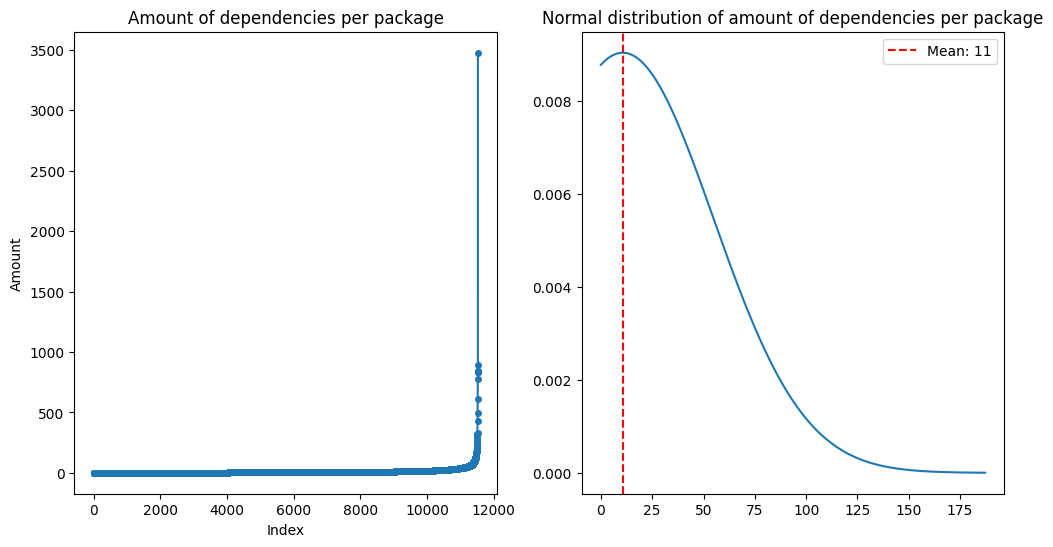

,vulnerabilities,author,author_email,classifiers,description,download_url,keywords,maintainer,maintainer_email,name,package_url,platform,project_url,project_urls,provides_extra,requires_dist,requires_python,summary,version,dependencies
3247,NaN,NaN,Allen Barker <Allen.L.Barker@gmail.com>,"[Development Status :: 4 - Beta, Intended Audi...",\nstrip-hints\n===========\n\nThis package pro...,NaN,"annotations, hints, strip, type, typing",NaN,NaN,strip-hints,https://pypi.org/project/strip-hints/,NaN,https://pypi.org/project/strip-hints/,{'Homepage': 'https://github.com/abarker/strip...,NaN,[wheel],NaN,Function and command-line program to strip Pyt...,0.1.13,[wheel]
3241,NaN,Yash Todi,yashtodi94@gmail.com,"[Development Status :: 4 - Beta, Framework :: ...",=======================\npytest-custom_exit_co...,NaN,NaN,Yash Todi,yashtodi94@gmail.com,pytest-custom-exit-code,https://pypi.org/project/pytest-custom-exit-code/,NaN,https://pypi.org/project/pytest-custom-exit-code/,{'Homepage': 'https://github.com/yashtodi94/py...,NaN,[pytest (>=4.0.2)],">2.7, !=3.0.*, !=3.1.*, !=3.2.*, !=3.3.*",Exit pytest test session with custom exit code...,0.3.0,[pytest]
3281,NaN,Ethan Furman,ethan@stoneleaf.us,"[Development Status :: 4 - Beta, Intended Audi...","\nCurrently supports dBase III, Clipper, FoxPr...",NaN,NaN,NaN,NaN,dbf,https://pypi.org/project/dbf/,NaN,https://pypi.org/project/dbf/,{'Homepage': 'https://github.com/ethanfurman/d...,NaN,[aenum],NaN,"Pure python package for reading/writing dBase,...",0.99.11,[aenum]
13661,NaN,Works Applications,sudachi@worksap.co.jp,NaN,# Sudachi Dictionary for SudachiPy\n\n- [Works...,NaN,NaN,NaN,NaN,SudachiDict-core,https://pypi.org/project/SudachiDict-core/,NaN,https://pypi.org/project/SudachiDict-core/,{'Homepage': 'https://github.com/WorksApplicat...,NaN,"[SudachiPy<0.7,>=0.5]",NaN,Sudachi Dictionary for SudachiPy - Core Edition,20250825,[SudachiPy]
13660,NaN,The Great Expectations Team,team@greatexpectations.io,"[Development Status :: 4 - Beta, Intended Audi...",Great Expectations community contributions pac...,NaN,data science testing pipeline data quality dat...,NaN,NaN,great-expectations-experimental,https://pypi.org/project/great-expectations-ex...,NaN,https://pypi.org/project/great-expectations-ex...,{'Homepage': 'https://github.com/great-expecta...,NaN,[great-expectations>=0.13.0],NaN,Always know what to expect from your data.,0.1.20240917055,[great-expectations]
13653,NaN,NaN,Adam Johnson <me@adamj.eu>,"[Development Status :: 5 - Production/Stable, ...",================\nflake8-no-pep420\n==========...,NaN,flake8,NaN,NaN,flake8-no-pep420,https://pypi.org/project/flake8-no-pep420/,NaN,https://pypi.org/project/flake8-no-pep420/,{'Changelog': 'https://github.com/adamchainz/f...,NaN,"[flake8!=3.2,>=3]",>=3.9,A flake8 plugin to ban PEP-420 implicit namesp...,2.9.0,[flake8]
13649,NaN,Ryan Fleming,rfleming71@users.noreply.github.com,"[Natural Language :: English, Programming Lang...",NaN,NaN,"octoprint,homeassistant",NaN,NaN,pyoctoprintapi,https://pypi.org/project/pyoctoprintapi/,NaN,https://pypi.org/project/pyoctoprintapi/,{'Homepage': 'https://github.com/rfleming71/py...,NaN,[aiohttp],NaN,An asynchronous Python library for communicati...,0.1.14,[aiohttp]
13647,NaN,Omar Kohl,omarkohl@gmail.com,"[Development Status :: 5 - Production/Stable, ...",================\npytest-datafiles\n==========...,NaN,pytest datafiles tmp_path,Omar Kohl,omarkohl@gmail.com,pytest-datafiles,https://pypi.org/project/pytest-datafiles/,NaN,https://pypi.org/project/pytest-datafiles/,{'Homepage': 'https://github.com/omarkohl/pyte...,NaN,[pytest (>=3.6)],NaN,py.test plugin to create a 'tmp_path' containi...,3.0.0,[pytest]
13645,NaN,Ioannis Filippidis,jfilippidis@gmail.com,"[Development Status :: 2 - Pre-Alpha, Intended...",[![Build Status][build_img]][ci]\n\n\nAbout\n=...,NaN,"lexing, parsing, syntax tree, abstract syntax ...",NaN,NaN,astutils,https://pypi.org/project/astutils/,NaN,https://pypi.org/project/astutils/,{'Homepage': 'https

,vulnerabilities,author,author_email,classifiers,description,download_url,keywords,maintainer,maintainer_email,name,package_url,platform,project_url,project_urls,provides_extra,requires_dist,requires_python,summary,version,dependencies
9296,"[{'aliases': ['CVE-2024-45855'], 'details': 'D...",MindsDB Inc,jorge@mindsdb.com,"[Operating System :: OS Independent, Programmi...","\n\n<a name=""readme-top""></a>\n\n<div align=""c...",https://pypi.org/project/mindsdb/,NaN,NaN,NaN,MindsDB,https://pypi.org/project/MindsDB/,NaN,https://pypi.org/project/MindsDB/,{'Download': 'https://pypi.org/project/mindsdb...,"[dev, langfuse, opentelemetry, test, all-extra...","[packaging, flask==3.0.3, werkzeug==3.0.6, fla...","<3.14,>=3.10",MindsDB's AI SQL Server enables developers to ...,25.9.1.2,"[packaging, flask, werkzeug, flask-restx, pand..."
8251,NaN,OpenMetadata Committers,NaN,NaN,---\nThis guide will help you setup the Ingest...,NaN,NaN,NaN,NaN,openmetadata-ingestion,https://pypi.org/project/openmetadata-ingestion/,NaN,https://pypi.org/project/openmetadata-ingestion/,{'Documentation': 'https://docs.open-metadata....,"[airflow, all, all-dev-env, amundsen, athena, ...","[kubernetes>=21.0.0, antlr4-python3-runtime==4...",>=3.9,Ingestion Framework for OpenMetadata,1.9.7.1,"[kubernetes, antlr4-python3-runtime, shapely, ..."
13421,NaN,Vlad Emelianov,vlad.emelianov.nz@gmail.com,"[Development Status :: 5 - Production/Stable, ...","<a id=""types-aioboto3""></a>\n\n# types-aioboto...",NaN,aioboto3 aioboto3-stubs type-annotations types...,NaN,NaN,types-aioboto3,https://pypi.org/project/types-aioboto3/,NaN,https://pypi.org/project/types-aioboto3/,{'Documentation': 'https://youtype.github.io/t...,"[full, aioboto3, all, essential, accessanalyze...","[botocore-stubs, types-aiobotocore, types-s3tr...",>=3.8,Type annotations for aioboto3 15.1.0 generated...,15.1.0,"[botocore-stubs, types-aiobotocore, types-s3tr..."
12286,NaN,Vlad Emelianov,vlad.emelianov.nz@gmail.com,"[Development Status :: 5 - Production/Stable, ...","<a id=""types-boto3""></a>\n\n# types-boto3\n\n[...",NaN,boto3 boto3-stubs type-annotations typeshed au...,NaN,NaN,types-boto3,https://pypi.org/project/types-boto3/,NaN,https://pypi.org/project/types-boto3/,{'Documentation': 'https://youtype.github.io/t...,"[full, boto3, all, essential, accessanalyzer, ...","[botocore-stubs, types-s3transfer, typing-exte...",>=3.8,Type annotations for boto3 1.40.30 generated w...,1.40.30,"[botocore-stubs, types-s3transfer, typing-exte..."
1365,NaN,Vlad Emelianov,vlad.emelianov.nz@gmail.com,"[Development Status :: 5 - Production/Stable, ...","<a id=""boto3-stubs""></a>\n\n# boto3-stubs\n\n[...",NaN,boto3 boto3-stubs type-annotations typeshed au...,NaN,NaN,boto3-stubs,https://pypi.org/project/boto3-stubs/,NaN,https://pypi.org/project/boto3-stubs/,{'Documentation': 'https://youtype.github.io/b...,"[full, boto3, all, essential, accessanalyzer, ...","[botocore-stubs, types-s3transfer, typing-exte...",>=3.8,Type annotations for boto3 1.40.30 generated w...,1.40.30,"[botocore-stubs, types-s3transfer, typing-exte..."
13528,NaN,Vlad Emelianov,vlad.emelianov.nz@gmail.com,"[Development Status :: 5 - Production/Stable, ...","<a id=""boto3-stubs-lite""></a>\n\n# boto3-stubs...",NaN,boto3 boto3-stubs type-annotations typeshed au...,NaN,NaN,boto3-stubs-lite,https://pypi.org/project/boto3-stubs-lite/,NaN,https://pypi.org/project/boto3-stubs-lite/,{'Documentation': 'https://youtype.github.io/b...,"[full, boto3, all, essential, accessanalyzer, ...","[botocore-stubs, types-s3transfer, typing-exte...",>=3.8,Lite type annotations for boto3 1.40.30 genera...,1.40.30,"[botocore-stubs, types-s3transfer, typing-exte..."
8193,NaN,Vlad Emelianov,vlad.emelianov.nz@gmail.com,"[Development Status :: 5 - Production/Stable, ...","<a id=""types-aiobotocore-lite""></a>\n\n# types...",NaN,aiobotocore aiobotocore-stubs type-annotations...,NaN,NaN,types-aiobotocore-lite,https://pypi.org/project/types-aiobotocore-lite/,NaN,https://pypi.org/project/

In [50]:
records = df[df["dependencies"].notna()]["dependencies"].to_list()
records = sorted(records, key=len)
amount = [len(r) for r in records]
mean = np.mean(amount)
median = np.median(amount)
std = np.std(amount)

print(f"mean: {round(mean)}", f"median: {round(median)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(range(len(amount)), amount, marker="o", markersize=4)
ax1.set_xlabel("Index")
ax1.set_ylabel("Amount")
ax1.set_title("Amount of dependencies per package")

x = np.linspace(0, mean + 4*std, 1000)
ax2.plot(x, norm.pdf(x, loc=mean, scale=std))
ax2.set_title("Normal distribution of amount of dependencies per package")
ax2.axvline(mean, color="red", linestyle="--", label=f"Mean: {round(mean)}")
ax2.legend()
plt.show()

df_temp = df[df["dependencies"].notna()]
df_temp = df_temp.sort_values(by="dependencies", key=lambda x: x.str.len())
display(df_temp.head(10), df_temp.tail(10))

![dependencies_duplicates_due_to_multiple_dependency_groups](images/6.png)

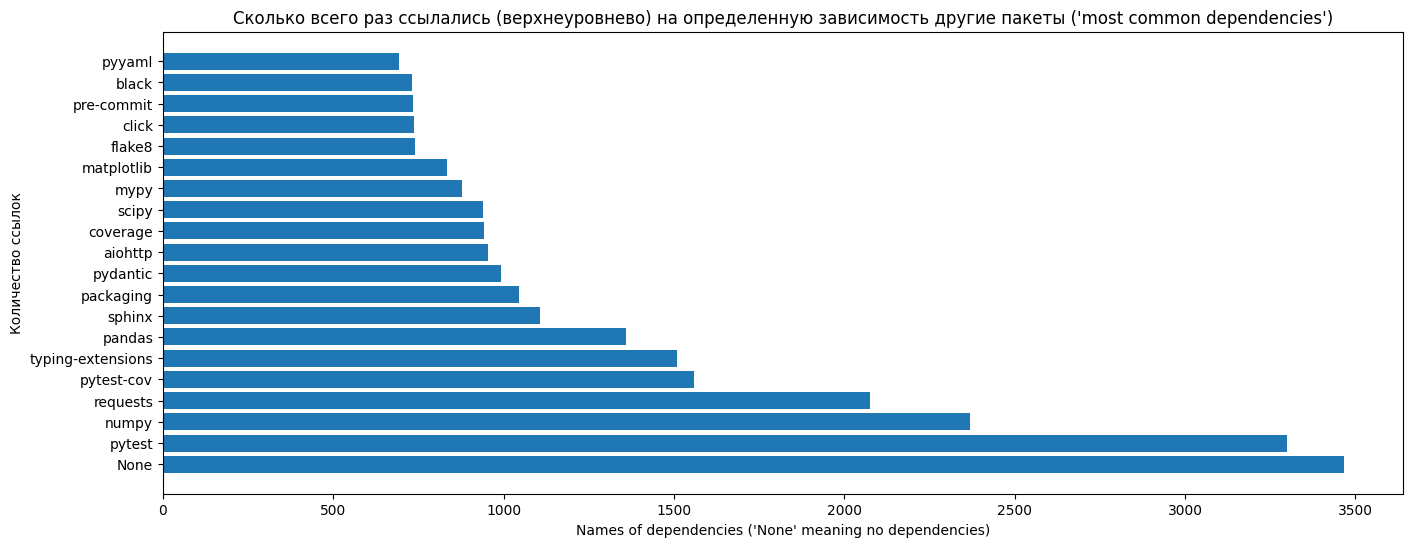

In [51]:
links = Counter()

def count_links(row: pd.Series) -> pd.Series:
    if not isinstance(row["dependencies"], list):
        links[None] += 1
        return row
    
    for dependency in row["dependencies"]:
        links[dependency] += 1
    return row

df = df.apply(count_links, axis=1)

# TODO: handle without dependencies in other way
links["None"] = links[None]
del links[None]

common = links.most_common(20)
names = [value[0] for value in common]
links_counts = [value[1] for value in common]
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(names, links_counts)
ax.set_xlabel("Names of dependencies ('None' meaning no dependencies)")
ax.set_ylabel("Количество ссылок")
ax.set_title("Сколько всего раз ссылались (верхнеуровнево) на определенную зависимость другие пакеты ('most common dependencies')")
plt.show()

![dependency_graph](images/4.png)

In [356]:
def construct_graph(data):
    graph = nx.DiGraph()
    graph.add_node(data["name"], **{"type_": "dependent"})
    
    # if None, don't add edges and nodes
    if not isinstance(data["dependencies"], list):
        return graph
    
    graph.add_nodes_from([(dependency, {"type_": "dependency"}) for dependency in data["dependencies"]]) 
    
    # add edges from dependent to all dependency
    # graph.add_edges_from([(dependent, dependency), (dependent, dependency), ...)
    dependencies_nodes = [] 
    for node, attrs in graph.nodes(data=True):
        if attrs["type_"] == "dependent":
            dependent_node = node
            continue
        dependencies_nodes.append(node)
    graph.add_edges_from((dependent_node, dependency_node) for dependency_node in dependencies_nodes)
    return graph

# ищем верхнеуровневые зависимости у тех найденных крупных зависимостей
# note: тут выходит 17 вместо 20, ведь один из них это None и 2 зависимости еще нету в нашем датасете (необходимо догружать отдельно)
df_slice = df[df["name"].isin(names)]
slices = [{"name": row["name"], "dependencies": row["dependencies"]} for index, row in df_slice.iterrows()]
# TODO: graph of graphs (subgraphs) or list of graphs

for i, data in enumerate(slices):
    nt = Network(height="1000px", width="1000px", notebook=True, directed=True, cdn_resources="remote")
    internal_graph = construct_graph(data)
    nt.from_nx(internal_graph)
    nt.show(f"../local_data/graphs/subgraph_{i}.html")

../local_data/graphs/subgraph_0.html
../local_data/graphs/subgraph_1.html
../local_data/graphs/subgraph_2.html
../local_data/graphs/subgraph_3.html
../local_data/graphs/subgraph_4.html
../local_data/graphs/subgraph_5.html
../local_data/graphs/subgraph_6.html
../local_data/graphs/subgraph_7.html
../local_data/graphs/subgraph_8.html
../local_data/graphs/subgraph_9.html
../local_data/graphs/subgraph_10.html
../local_data/graphs/subgraph_11.html
../local_data/graphs/subgraph_12.html
../local_data/graphs/subgraph_13.html
../local_data/graphs/subgraph_14.html
../local_data/graphs/subgraph_15.html
../local_data/graphs/subgraph_16.html


# Вопрос C.

In [52]:
df_temp = df[df["vulnerabilities"].notna()]
cves = df_temp["vulnerabilities"].to_list()
names = df_temp["name"]

unique_cves = set()
for name, cve in zip(names, cves):
    print(f"{name}: {cve}")
    print("---------------")
    for incident in cve:
        unique_cves.add(incident["id"])
print(unique_cves, len(unique_cves))

ecdsa: [{'aliases': ['CVE-2024-23342'], 'details': 'python-ecdsa has been found to be subject to a Minerva timing attack on the P-256 curve. Using the `ecdsa.SigningKey.sign_digest()` API function and timing signatures an attacker can leak the internal nonce which may allow for private key discovery. Both ECDSA signatures, key generation, and ECDH operations are affected. ECDSA signature verification is unaffected. The python-ecdsa project considers side channel attacks out of scope for the project and there is no planned fix.', 'fixed_in': [], 'id': 'GHSA-wj6h-64fc-37mp', 'link': 'https://osv.dev/vulnerability/GHSA-wj6h-64fc-37mp', 'source': 'osv', 'summary': None, 'withdrawn': None}]
---------------
pycel: [{'aliases': ['CVE-2024-53924'], 'details': 'Pycel through 1.0b30, when operating on an untrusted spreadsheet, allows code execution via a crafted formula in a cell, such as one beginning with the `=IF(A1=200, eval("__import__(\'os\').system(` substring.', 'fixed_in': [], 'id': 'GH

# Вопрос D.

In [57]:
# тут произошла непонятная ситуация
# на сайте pypi (как внешний источник) указан (к примеру https://pypi.org/project/types-passlib/)
# там указан один maintainer (https://pypi.org/user/typeshed_bot/)
# но когда мы обращаемся к pypi API, то там этих данных вовсе нету
display(df[df["maintainer"].isna() & df["author"].isna() & df["author_email"].isna() & df["maintainer_email"].isna()])

df["merged_holder"] = ""
columns = ["maintainer", "author", "author_email", "maintainer_email"]
display(df[columns])

,vulnerabilities,author,author_email,classifiers,description,download_url,keywords,maintainer,maintainer_email,name,...,platform,project_url,project_urls,provides_extra,requires_dist,requires_python,summary,version,dependencies,merged_holder
7,NaN,NaN,NaN,"[Programming Language :: Python :: 3, Typing :...",## Typing stubs for passlib\n\nThis is a [PEP ...,NaN,NaN,NaN,NaN,types-passlib,...,NaN,https://pypi.org/project/types-passlib/,{'Changes': 'https://github.com/typeshed-inter...,NaN,NaN,>=3.9,Typing stubs for passlib,1.7.7.20250602,NaN,
27,NaN,NaN,NaN,"[Development Status :: 5 - Production/Stable, ...",# Antithesis Python\n\nThis library provides m...,NaN,"antithesis, sdk, autonomous, testing",NaN,NaN,antithesis,...,NaN,https://pypi.org/project/antithesis/,{'documentation': 'https://antithesis.com/docs...,NaN,[cffi>=1.16.0],>=3.9,Antithesis SDK for Python,0.1.18,[cffi],
35,NaN,NaN,NaN,NaN,# LangGraph SQLite Checkpoint\n\nImplementatio...,NaN,NaN,NaN,NaN,langgraph-checkpoint-sqlite,...,NaN,https://pypi.org/project/langgraph-checkpoint-...,{'Repository': 'https://www.github.com/langcha...,NaN,"[aiosqlite>=0.20, langgraph-checkpoint<3.0.0,>...",>=3.9,Library with a SQLite implementation of LangGr...,2.0.11,"[aiosqlite, langgraph-checkpoint, sqlite-vec]",
40,NaN,NaN,NaN,"[Programming Language :: Python :: 3, Typing :...",## Typing stubs for cffi\n\nThis is a [type st...,NaN,NaN,NaN,NaN,types-cffi,...,NaN,https://pypi.org/project/types-cffi/,{'Changes': 'https://github.com/typeshed-inter...,NaN,[types-setuptools],>=3.9,Typing stubs for cffi,1.17.0.20250822,[types-setuptools],
49,NaN,NaN,NaN,"[License :: OSI Approved :: MIT License, Opera...",# AutoGen Extensions\n\n- [Documentation](http...,NaN,NaN,NaN,NaN,autogen-ext,...,NaN,https://pypi.org/project/autogen-ext/,NaN,"[anthropic, azure, canvas, chromadb, diskcache...","[autogen-core==0.7.4, anthropic>=0.48; extra =...",>=3.10,AutoGen extensions library,0.7.4,"[autogen-core, anthropic, azure-ai-inference, ...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14947,NaN,NaN,NaN,"[Intended Audience :: Developers, License :: O...","Hear ye, hear ye, says the ``towncrier``\n====...",NaN,NaN,NaN,NaN,towncrier,...,NaN,https://pypi.org/project/towncrier/,{'Chat': 'https://web.libera.chat/?channels=%2...,[dev],"[click, importlib-metadata>=4.6; python_versio...",>=3.9,Building newsfiles for your project.,25.8.0,"[click, importlib-metadata, importlib-resource...",
14965,NaN,NaN,NaN,[Programming Language :: Python :: Implementat...,# sphn\n\nPython bindings for the [symphonia](...,NaN,"pyo3, audio",NaN,NaN,sphn,...,NaN,https://pypi.org/project/sphn/,{'Source Code': 'https://github.com/LaurentMaz...,NaN,NaN,>=3.8,pyo3 wrappers to read/write audio files,0.2.0,NaN,
14977,NaN,NaN,NaN,NaN,[![Actions Status](https://github.com/pulumi/p...,NaN,"pulumi, random",NaN,NaN,pulumi-random,...,NaN,https://pypi.org/project/pulumi-random/,"{'Homepage': 'https://pulumi.io', 'Repository'...",NaN,"[parver>=0.2.1, pulumi<4.0.0,>=3.165.0, semver...",>=3.9,A Pulumi package to safely use randomness in P...,4.18.3,"[parver, pulumi, semver, typing-extensions]",
14988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stubdefaulter,...,NaN,https://pypi.org/project/stubdefaulter/,NaN,NaN,"[libcst, termcolor>=2, tomli, typeshed-client>...",>=3.7,Autoadd default values to stubs,0.1.0,"[libcst, termcolor, tomli, typeshed-client, bl...",


,maintainer,author,author_email,maintainer_email
0,NaN,Pavel Yakubovskiy,qubvel@gmail.com,NaN
1,NaN,Ali-Akber Saifee,ali@indydevs.org,NaN
2,NaN,NaN,kyleking <dev.act.kyle@gmail.com>,NaN
3,NaN,hect0x7,93357912+hect0x7@users.noreply.github.com,NaN
4,NaN,Rick van Hattem,Wolph@Wol.ph,NaN
...,...,...,...,...
14993,NaN,"Tore Hanssen, Jiakan Wang","tore@statsig.com, jkw@statsig.com",NaN
14994,Executable Book Project,Taneli Hukkinen,NaN,executablebooks@gmail.com
14995,NaN,Geoffrey Lentner,glentner@purdue.edu,NaN
14996,NaN,Artur Barseghyan,artur.barseghyan@gmail.com,NaN


![image](images/5.png)

In [69]:
df_author = df[df["author"].notna()]
df_author = df_author[df_author.duplicated(subset=["author"], keep=False)]

df_result = (
    df_author
    .groupby("author")
    .agg(
        amount_of_packages=("name", "count"),
        names_of_packages=("name", list)
    )
    .reset_index()
    .sort_values(by=["amount_of_packages"], ascending=False)
)

df_result.head(20)

,author,amount_of_packages,names_of_packages
1076,Vlad Emelianov,481,"[types-aiobotocore-lambda, types-aiobotocore-s..."
677,Microsoft Corporation,265,"[azure-iot-device, azure-cli-profile, azure-mg..."
61,Amazon Web Services,165,"[projen, aws-cdk.aws-dynamodb, awslabs.aws-doc..."
885,Ronald Oussoren,160,"[pyobjc-framework-EventKit, pyobjc-framework-G..."
384,Google LLC,126,"[google-cloud-pubsublite, google-cloud-resourc..."
761,OpenStack,73,"[oslo.metrics, oslo.privsep, oslo.i18n, etcd3g..."
1108,Zope Foundation and Contributors,63,"[RestrictedPython, Zope, zope.ptresource, zope..."
1134,edX,49,"[edx-event-bus-kafka, edx-tincan-py35, edx-res..."
448,J. Nick Koston,47,"[qingping-ble, aiozoneinfo, usb-devices, aiodi..."
383,Google Inc.,47,"[tensorflow-text, tensorflow-transform, tensor..."


# Вопрос E.

In [ ]:
# TODO: text clustering based on [classifiers, description, summary, keywords]
# visualizing text and data clustering

1. Уточняющие вопросы:
    - Есть ли у вас нужные данные?
        - Скорее нет, чем да, ведь необходима полная выгрузка из PyPI. Полученная выборка не может отражать полное детальное состояние на текущий момент или быть репрезентативной.
    - Нужны ли другие данные?
        - Да, нужны как сказал ранее, но также нужны другие формы данных (не только метаданные, но также сами source файлы / бинарники и т.д.) и источники (альтернативные репозитории пакетов: debian, github, etc.).
    - Есть ли у вас правильный вопрос?
        - Наверное, ведь получена информация из данных и она частично подтверждает выстроенные гипотезы. Однако, самих вопросов думаю было составлено мало, ведь тема довольно разносторонняя и неоднозначная (нерешанная дилемма и много позиций на этот счет).

2. Контрольные вопросы:
    - Какова основная цель исследовательского анализа данных (EDA)? Опишите, как формулировка точного вопроса помогает в этом процессе.
        - Цель исследовательского анализа данных (EDA) это первичное ознакомление с полученными данными (их содержанием, структурой, элементами), а также их первичная обработка или трансформация. Формулировка точного вопроса может помочь отделить необходимые данные от других или уменьшить потенциальную выборку (сокращение количество данных для поиска) на раннем этапе, тем самым упростить нам работу.
    - Объясните, почему сверка данных с внешними источниками является критически важным шагом в EDA.
        - Во время сбора данных или их обработки, могут случайно потеряться какие-либо записи или быть недостатки (дубликаты, пустые значения, отличия, и т.д.) - это способ удостовериться в их качестве, поиск систематических ошибок, и другое.
    - Обоснуйте, почему после получения простого решения на поставленный вопрос необходимо провести его проверку.
        - Решение или вопрос могли быть неоднозначными (включать только одну категорию данных или выборку) или исследователь мог подогнать данные под ответ, что ведет к риску поверхностного решения и предвзятости результата.
    - Какой фактор не важен при работе с предиктивными вопросами?
        - Предиктивные вопросы относятся к категории "prediction / forecasting" задачам, они зачастую основываются на данных и получения их в динамике (к примеру, "сколько будет сумма загрузок файлов данного пакета в ближайшие 10 дней?" - основываются на прошлых скачиваниях и общих трендов) и меньше на личные предпочтения или субъективное мнение исследователя (хотя это тоже не стоит однозначно исключать).
    - Что считается характеристикой хорошего вопроса?
        - Вопрос, ведущий и направляющий к получению качественных инсайдов по той или иной теме (информационную базу из сырых данных), и задающий гипотезу для его решения.
    - В чем заключается основное различие между функциональными и нефункциональными требованиями?
        - Функциональные требования описывают функционал системы (что она обязана делать, возможности системы в целом, части или элементы системы), а не функциональные описывают характеристики системы (качественные и количественные показатели: безопасность, доступность, производительность, и многое другое).
    - Объясните взаимосвязь между системным анализом, синтезом (проектированием) и моделированием в непрерывном цикле улучшения.
        - Данные элементы все необходимы в непрерывном цикле улучшения, ведь система каждый раз инкрентально меняется (пока она находится в эксплуатации) под различные требования и задачи (внутренние или внешние то есть под влияением экосистемы или самой себя), и необходимо каждый раз вести анализ целесообразности тех или иных намеренний вместе с предоставляемыми решениями.